In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/WS_analysis_results_99.csv

In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/Acoustic_Analysis_Results.csv

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras import layers, initializers
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.ensemble import RandomForestClassifier

In [ ]:
prints = False

data = pd.read_csv('WS_analysis_results_99.csv', delimiter=',', dtype=None, encoding=None)
data = data.rename(columns={'MOMENTS': 'Filename'}) # rename the MOMENTS column to the filename column

data_2 = pd.read_csv('Acoustic_Analysis_Results.csv', delimiter=',', dtype=None, encoding=None)
data_2 = data_2.rename(columns={'Unnamed: 0': 'Filename'}) # rename the not-named column to the filename column
data_2 = data_2.fillna(data_2.mean(numeric_only=True))

n_samples = 200
n_windows = 99
n_features = 32

dataset = np.ones(shape=(n_samples * n_windows, n_features))
dataset_incr = np.ones(shape=(n_samples * (n_windows+1), n_features))
labels  = np.zeros(shape=(n_samples * n_windows))
labels_incr = np.zeros(shape=(n_samples * (n_windows+1)))

for column_name in data.columns:
  if column_name == 'Filename': continue
  data[column_name] = (data[column_name] - np.mean(data[column_name])) / np.std(data[column_name])

"""
for column_name in data_2.columns:
  if column_name == 'Filename': continue
  data_2[column_name] = (data_2[column_name] - np.mean(data_2[column_name])) / np.std(data_2[column_name])
"""

for index, row in data.iterrows():

  filename = row['Filename'][:-4]
  if prints: print("filename without wav: ", filename)

  label, n_sample, n_part = filename.split('_')
  n_sample = int(n_sample)
  n_part   = int(n_part)

  if prints:
    print("label: ", label)
    print("n_sample: ", n_sample)
    print("n_part: ", n_part)

  if label == 'I':
    labels[index] = 1
    labels_incr[index] = 1

  row = data.iloc[index].to_numpy()[1:]
  if prints:
    print("row.shape: ", row.shape)
    print("dataset.shape:  ", dataset.shape)
    print("dataset[n_sample, n_part, :].shape:  ", dataset[n_sample, n_part, :].shape, '\n\n')
  dataset[index, :] = row
  #dataset_incr[index, :] = row

"""
index += 1
for index_data_2, row in data_2.iterrows():

  label = row['Filename'][0]
  if label == 'I':
    labels_incr[index + index_data_2] = 1

data_2 = data_2.drop(columns=['Filename'])
data_2 = data_2.to_numpy()

for index_data_2, features in enumerate(data_2):
  dataset_incr[index + index_data_2] = features
"""

rng     = np.random.default_rng() # shuffle time
shuffle = rng.choice(n_samples*n_windows, size=(n_samples * n_windows), replace=False)
data    = dataset[shuffle]
labels  = labels[shuffle]

"""
shuffle_incr = rng.choice(n_samples*(n_windows+1), size=(n_samples * (n_windows+1)), replace=False)
data_incr    = dataset_incr[shuffle_incr]
labels_incr  = labels_incr[shuffle_incr]
"""

print("---------------------------------")
print("|  data.shape:   ", data.shape, "   |")
print("|  labels.shape: ", labels.shape, "      |")
print("---------------------------------")
"""
print("---------------------------------")
print("|  data_incr.shape:", data_incr.shape, " |")
print("|  labels.shape:   ", labels_incr.shape, "    |")
print("---------------------------------")
""";

---------------------------------
|  data.shape:    (19800, 32)    |
|  labels.shape:  (19800,)       |
---------------------------------


In [ ]:
def plot_things(history):
  fig = plt.figure(figsize=(10, 8))
  plt.subplot(2,1,1)
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  fig = plt.figure(figsize=(10, 8))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def get_model(dropout_rate=0.3, nb_neurons=30):

  model = tf.keras.Sequential()

  model.add(layers.Dense(nb_neurons, input_shape=(n_features,)))
  model.add(layers.ReLU())
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(1, activation='sigmoid'))

  optimizer = Adam(0.003, beta_1=0.5)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [ ]:
model = get_model()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(data, labels, epochs=500, validation_split=0.3, callbacks=[callback])

Epoch 1/500
434/434 [==============================] - 2s 3ms/step - loss: 0.5342 - binary_accuracy: 0.7419 - val_loss: 0.4776 - val_binary_accuracy: 0.7704
Epoch 2/500
434/434 [==============================] - 1s 2ms/step - loss: 0.4801 - binary_accuracy: 0.7709 - val_loss: 0.4600 - val_binary_accuracy: 0.7822
Epoch 3/500
434/434 [==============================] - 1s 2ms/step - loss: 0.4692 - binary_accuracy: 0.7794 - val_loss: 0.4567 - val_binary_accuracy: 0.7865
Epoch 4/500
434/434 [==============================] - 1s 2ms/step - loss: 0.4571 - binary_accuracy: 0.7862 - val_loss: 0.4482 - val_binary_accuracy: 0.7892
Epoch 5/500
434/434 [==============================] - 1s 2ms/step - loss: 0.4520 - binary_accuracy: 0.7910 - val_loss: 0.4457 - val_binary_accuracy: 0.7928
Epoch 6/500
434/434 [==============================] - 1s 2ms/step - loss: 0.4496 - binary_accuracy: 0.7903 - val_loss: 0.4383 - val_binary_accuracy: 0.7953
Epoch 7/500
434/434 [==============================] - 1s 

In [ ]:
plot_things(history)

NameError: ignored

In [ ]:
number_splits = 6
number_runs   = 5
results_acc   = np.zeros(shape=(number_runs, number_splits))
results_loss  = np.zeros(shape=(number_runs, number_splits))


for run in range(number_runs):
  
  print("\n\n\nDoing the run number ", run+1)
  kfold = KFold(n_splits=number_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for split,(fold_train, fold_test) in enumerate(kfold.split(data, labels)):

    model = get_model()
    print("Training the fold number ", fold_no,"\n")
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
    history = model.fit(data[fold_train], labels[fold_train], epochs=200, callbacks=[callback])

    scores = model.evaluate(data[fold_test], labels[fold_test], verbose=0)
    print("For the fold number ",  fold_no, ":\nloss = ", scores[0], "\naccuracy = ", scores[1]*100,"%")
    results_acc[run][split] = scores[1] * 100
    results_loss[run][split] = scores[0]

    # Increase fold number
    fold_no = fold_no + 1


results_acc = np.mean(results_acc, axis=1)
results_loss = np.mean(results_loss, axis=1)

results_acc = np.mean(results_acc)
results_loss = np.mean(results_loss)

print("\n\n\nWe obtain the following results:\nmean accuracy: ",results_acc,"%", "\nmean loss:",results_loss)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
516/516 [==============================] - 1s 2ms/step - loss: 0.4166 - binary_accuracy: 0.8079
Epoch 52/200
516/516 [==============================] - 1s 2ms/step - loss: 0.4250 - binary_accuracy: 0.8032
Epoch 53/200
516/516 [==============================] - 1s 2ms/step - loss: 0.4220 - binary_accuracy: 0.8070
Epoch 54/200
516/516 [==============================] - 1s 2ms/step - loss: 0.4192 - binary_accuracy: 0.8068
Epoch 55/200
516/516 [==============================] - 1s 2ms/step - loss: 0.4223 - binary_accuracy: 0.8085
Epoch 56/200
516/516 [==============================] - 1s 2ms/step - loss: 0.4168 - binary_accuracy: 0.8082
Epoch 57/200
516/516 [==============================] - 1s 2ms/step - loss: 0.4190 - binary_accuracy: 0.8056
Epoch 58/200
516/516 [==============================] - 1s 2ms/step - loss: 0.4158 - binary_accuracy: 0.8089
Epoch 59/200
516/516 [==============================] - 1s 2ms/

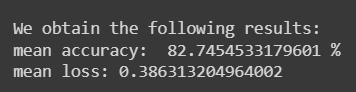